In [1]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import random
import operator
from bisect import bisect
%matplotlib inline

In [231]:
class TSP(object):
    def __init__(self,start=1,dissipation=.2,tolerance=.2,alpha=1.0,beta=1.0,explore=1.0):
        #inputs
        self.dissipation=dissipation
        self.explore=explore
        self.tolerance=tolerance
        self.alpha=alpha
        self.beta=beta
        self.start=start
        self.step=0
        
        #setup
        self.history_d={} #holds decisions about node order
        self.history_k={}
        self.history_s={}
        self.tsp=self.init_tsp()
        #self.tsp=tsp_single()
        
        #Tracking - last[type][element][node history]
        ##type - p, dist, score, route, dec
        ##element - edge, edge, step, obj, none
        self.last={'p':{},'dist':{},'score':{},'route':{},'dec':{}}
        for e in self.tsp.edges():
            self.last['p'][e]=[]
            self.last['dist'][e]=[]
        for i in xrange(self.tsp.number_of_nodes()-1):
            self.last['route'][i]=[]
        self.last['score'][0]=[]
        self.last['dec'][0]=[] #zero is placeholder
        
        #self.d=[self.start]
        self.d=[]
        self.d_change=[]
        self.history_d[self.step]=list(self.d)
        self.state=self.init_graph(self.tsp)
        self.history_s[self.step]=self.state.copy()
        self.k=self.init_k(self.state)
        #self.last_solution={}
        
        
    
    def init_tsp(self):
        tsp=nx.DiGraph()
        tsp.add_edge(1,2,dist=1.0)
        tsp.add_edge(2,1,dist=1.0)
        tsp.add_edge(1,3,dist=1.0)
        tsp.add_edge(3,1,dist=1.0)        
        tsp.add_edge(1,4,dist=2.0)
        tsp.add_edge(4,1,dist=2.0)
        tsp.add_edge(2,3,dist=3.0)
        tsp.add_edge(3,2,dist=3.0)
        tsp.add_edge(2,4,dist=4.0)
        tsp.add_edge(4,2,dist=4.0)
        tsp.add_edge(3,4,dist=2.0)
        tsp.add_edge(4,3,dist=2.0)
        
        return tsp
        
    def init_graph(self,tsp):
        g=tsp.copy()
        for u,v in g.edges():
            g[u][v]['p']=0.5
            g[u][v]['dist']=0.0
            
        #initialize nodes

        #print g.edges(data=True)

        return g

    def init_k(self,g):
        k=nx.DiGraph()
        last_visited={}
        
        #k for edge data
        for u,v,d in g.edges(data=True):
            last_visited[(u,v)]={}
            n_label=k.number_of_nodes()+1
            k.add_node(n_label,label=(u,v),p=float(d['p']),step=self.step)
            self.last['p'][(u,v)].append(n_label)
            n_label=k.number_of_nodes()+1
            k.add_node(n_label,label=(u,v),dist=float(d['dist']),step=self.step)
            self.last['dist'][(u,v)].append(n_label)
            
        #k for decision
        n_label=k.number_of_nodes()+1
        k.add_node(n_label,label='decision', d=list(self.d), step=self.step)
        self.last['dec'][0].append(n_label)
        
        self.history_k[self.step]=k.copy()
        self.step+=1

        return k #,last_visited
    
    def walk(self):
        #initialize
        g=self.state.copy()
        tsp=self.tsp.copy()
        #tabu=[int(self.start)]
        if not self.d:
            tabu=[random.choice(g.nodes())]
        else:
            tabu=[self.d[0]]
            
        for i in xrange(g.number_of_nodes()-1):
            #get pheromone list
            n_l=[]
            p_l=[]
            h_l=[]
            dec_point=False #checks if this step is affected by a decision
            for n in g.nodes():
                if n not in tabu:
                    n_l.append(n)
                    p_l.append(g[tabu[-1]][n]['p'])
                    
                    if g[tabu[-1]][n]['p']==0.0: #Part of a decision process
                        dec_point=True
                    
                    
                    if g[tabu[-1]][n]['dist']==0.0:
                        h_l.append(self.explore) #10.0
                    else:
                        h_l.append(1.0/g[tabu[-1]][n]['dist'])
                    
            c_l=np.power(p_l,self.alpha)*np.power(h_l,self.beta)
            n_index=self.make_decision(c_l)
            new_n=n_l[n_index]
                
            #update k with edge from tau and dist to edge selection
            n_label=self.k.number_of_nodes()+1
            
            #label is edge number in solution, e is edge added
            self.k.add_node(n_label,label='selection',i=i,e=(tabu[-1],new_n),step=self.step)
            self.last['route'][i].append(n_label)
            
            for e_i in xrange(len(tabu)-1): #iterate through added edges
                #add constraining 
                last=self.last['route'][e_i][-1]
                self.k.add_edge(last,n_label,step=self.step,t=1)
            
            #if influenced by decision, edge from decision not other edge info
            if (dec_point or (len(n_l)==1 and len(self.d)==self.tsp.number_of_nodes())):
                #only edge from decision
                self.k.add_edge(self.last['dec'][0][-1],n_label,step=self.step, t=1)
                
            else:
                for n in n_l: #g.nodes():
                    #if n not in tabu: #only non tabu
                    if n != tabu[-1]: #no self-edge
                        e=(tabu[-1],n)
                        if (e[0],e[1]) not in self.tsp.edges(): #self.last_visited.keys():
                            e=(e[1],e[0])

                        self.k.add_edge(self.last['p'][e][-1],n_label,step=self.step, t=2)
                        self.k.add_edge(self.last['dist'][e][-1],n_label,step=self.step, t=2)
                    

                
            #append new node
            tabu.append(new_n)

        score=0.0
        e_r=[tuple(tabu[i:i+2]) for i in xrange(0,len(tabu), 1)]
        del e_r[-1]

        for e in e_r:
            score+=float(tsp[e[0]][e[1]]['dist'])

        return tuple(tabu), score

    def update_edges(self,route,score):
        g_t=self.state.copy()
        g=self.state.copy()
        p=float(self.dissipation)
        tsp=self.tsp.copy()
        
        #print 'before', g_t.edges(data=True)
        #print 'reduction', p
        
        #update k with rout
        #n_label=self.k.number_of_nodes()+1
        #self.k.add_node(n_label,label=route,step=self.step)
        #self.last_solution['route']=n_label
        
        # k edges from tsp edge info to route - now handled in walk
        #for e in self.last_visited:
            #self.k.add_edge(self.last_visited[e]['p'],n_label,step=self.step)
            #self.k.add_edge(self.last_visited[e]['dist'],n_label,step=self.step)
            
        
        e_r=[tuple(route[i:i+2]) for i in xrange(0,len(route), 1)]
        del e_r[-1]
        
        #update distances
        for e in e_r:
            sel_index=e_r.index(e)
            #check ordering
            if (e[0],e[1]) not in self.tsp.edges():
                e=(e[1],e[0])
            
            #update dist in k
            if g_t[e[0]][e[1]]['dist']==0.0:
                dist=float(tsp[e[0]][e[1]]['dist'])
                g_t[e[0]][e[1]]['dist']=dist
                
                #update k for changed distance
                n_label=self.k.number_of_nodes()+1
                last_n=self.last['dist'][(e[0],e[1])][-1]
                self.k.add_node(n_label,label=(e[0],e[1]),dist=float(dist),step=self.step)
                self.k.add_edge(last_n,n_label,step=self.step,t=2)
                self.k.add_edge(self.last['route'][sel_index][-1],n_label,step=self.step,t=1)
                
                self.last['dist'][(e[0],e[1])].append(n_label)
                

        #add k for score
        n_label=self.k.number_of_nodes()+1
        self.k.add_node(n_label,label='score',score=score,step=self.step)
        
        #add k from route selections to score
        for sel,n_list in self.last['route'].iteritems():
                self.k.add_edge(n_list[-1],n_label,step=self.step,t=1)
        
        self.last['score'][0].append(n_label)
        
        t_update=1.0/score
        for u,v,d in g_t.edges(data=True):
            #update pheromone
            g_t[u][v]['p']=float(g[u][v]['p'])*(1.0-p)
            
            #update k for pheromone reduction
            last_n=self.last['p'][(u,v)][-1]
            n_label=self.k.number_of_nodes()+1
            self.k.add_node(n_label,label=(u,v),p=float(d['p']),step=self.step)
            self.k.add_edge(last_n,n_label,step=self.step,t=2)
            self.last['p'][(u,v)].append(n_label)
        
        
        
        for e in e_r:
            sel_index=e_r.index(e)
            #check ordering
            if (e[0],e[1]) not in self.tsp.edges():
                e=(e[1],e[0])
            
            #update k for route score for distance
            last_n=self.last['dist'][(e[0],e[1])][-1]
            self.k.add_edge(last_n,self.last['score'][0][-1],step=self.step,t=1)
                
                
            #update pheromones on included edges    
            g_t[e[0]][e[1]]['p']=float(g_t[e[0]][e[1]]['p'])+t_update*p
            
            #update k for pheromone addition - add edge for walk update
            last_n=self.last['p'][(e[0],e[1])][-1]
            self.k.node[last_n]['p']=float(g_t[e[0]][e[1]]['p'])
            #n_label=self.k.number_of_nodes()+1
            #self.k.add_node(n_label,label=(e[0],e[1]),p=float(g_t[e[0]][e[1]]['p']),step=self.step)
            #self.k.add_edge(last_n,n_label,step=self.step)
            self.k.add_edge(self.last['route'][sel_index][-1],last_n,step=self.step,t=2)
            self.k.add_edge(self.last['score'][0][-1],last_n,step=self.step,t=2)
            #self.last_visited[(e[0],e[1])]['p']=n_label
        
        g_t=self.design(g_t,route,tolerance=self.tolerance)
        
        self.history_d[self.step]=list(self.d)
        self.history_k[self.step]=self.k.copy()
        self.history_s[self.step]=g_t.copy()
        self.step+=1
        #print 'after', g_t.edges(data=True)    
        return g_t

    def design(self,g,tabu,tolerance):
        #makes locks-in step in walk if p(1st node)-p(2nd node)
        #g=self.state.copy()
        g_t=g.copy()
        
        while True:
            if len(self.d)==(g.number_of_nodes()):
                break
                
            if not self.d:
                dec_node=tabu[0]
            else:
                dec_node=self.d[-1]
        
            #Get probabilities
            #get pheromone list
            n_l=[]
            p_l=[]
            h_l=[]
            for n in g.nodes():
                if (n not in self.d) and (n!=dec_node):
                    n_l.append(n)
                    p_l.append(g[dec_node][n]['p'])
                    #print dec_node,n, n!=dec_node
                    
                    if g[dec_node][n]['dist']==0.0: #only look at explored nodes
                        #h_l.append(0.0)
                        h_l.append(self.explore)
                        #print dec_node,n
                        #n_l.append(n)
                        #p_l.append(g[dec_node][n]['p'])
                        
                    else:
                        #h_l.append(1.0)
                        h_l.append(1.0/g[dec_node][n]['dist'])
                    
            ph_l=np.power(p_l,self.alpha)*np.power(h_l,1.0) #only use pheromone preference
            if sum(ph_l)==0.0:
                perc_l=[1.0/len(ph_l)]*len(ph_l)
            else:
                perc_l=[float(i)/sum(ph_l) for i in ph_l]
            l=list(perc_l)
            #print perc_l
            m_1=l.pop(l.index(max(l)))
            #print l,m_1
            #print m_1-max(l)
            
            if not l: #only one option
                #print 'decision'
                dec_index=perc_l.index(max(perc_l)) #decision index
                node=n_l[dec_index]
                self.d.append(node) #add node to decisions
                #print 'decision',self.step,dec_node,node,self.d_change
            
                #Eliminate other edge options
                for n in g.nodes():
                    if n not in self.d:
                        g_t[dec_node][n]['p']=0.0 #now prob of taking that edges is 0
                        
                #update k for decision
                n_label=self.k.number_of_nodes()+1
                self.k.add_node(n_label,label='dec',d=list(self.d),step=self.step)
                self.k.add_edge(self.last['dec'][0][-1],n_label,step=self.step,t=3)
                self.last['dec'][0].append(n_label)
                self.d_change.append(self.step)
                
            elif (m_1-max(l))>=tolerance: #prob gap is larger than tolerance 
                #print 'decision',self.step,dec_node
                if not self.d:
                    self.d.append(dec_node)
                    
                    #update k for decision
                    n_label=self.k.number_of_nodes()+1
                    self.k.add_node(n_label,label='dec',d=list(self.d),step=self.step)
                    self.k.add_edge(self.last['dec'][0][-1],n_label,step=self.step,t=3)
                    self.d_change.append(self.step)
                    for n in n_l:
                        e=(dec_node,n)
                        self.k.add_edge(self.last['p'][e][-1],n_label,step=self.step,t=2)
                
                dec_index=perc_l.index(max(perc_l)) #decision index
                #print n_l,dec_index
                node=n_l[dec_index]
                self.d.append(node) #add node to decisions
                #print dec_node,self.d
                #print 'decision',self.step,dec_node,node,self.d_change
            
                #Eliminate other edge options
                for n in g.nodes():
                    if n not in self.d:
                        #print n,dec_node
                        g_t[dec_node][n]['p']=0.0 #now prob of taking that edges is 0
                        
                #update k for decision
                n_label=self.k.number_of_nodes()+1
                self.k.add_node(n_label,label='dec',d=list(self.d),step=self.step)
                self.k.add_edge(self.last['dec'][0][-1],n_label,step=self.step,t=3)
                self.last['dec'][0].append(n_label)
                for n in n_l:
                    e=(dec_node,n)
                    self.k.add_edge(self.last['p'][e][-1],n_label,step=self.step,t=2)
                self.d_change.append(self.step)

                #break
            else:
                break
                
        #self.history_d[self.step]=self.d
            
        return g_t  
        

    def make_decision(self,ph_l):
        """
        Return decision index, based on pheromone list.
        """
        #convert pheromones to percentage
        if sum(ph_l)==0.0:
            percent_list=[1.0/len(ph_l)]*len(ph_l)
        else:
            percent_list = [float(i)/sum(ph_l) for i in ph_l]   
        cumulative_percent=np.cumsum(percent_list)
        #print cumulative_percent

        #Choose decision index
        select_index=bisect(cumulative_percent,np.random.uniform(0,1,1))

        return select_index









In [3]:
def tsp_single():
    tsp=nx.complete_graph(5,create_using=nx.DiGraph())
    for u,v in tsp.edges():
        tsp[u][v]['dist']=2.0

    tsp[2][4]['dist']=1.0
    #tsp[4][2]['dist']=1.0

    #print tsp.edges(data=True)
    return tsp

[1, 3, 4, 2]
[33, 33, 33, 33]


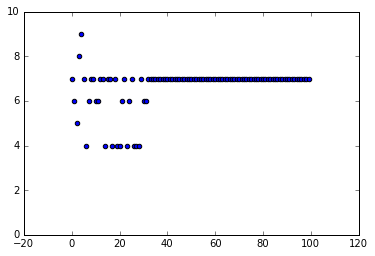

In [247]:
t=TSP(start=1,tolerance=.7,alpha=1.0,beta=1.0,dissipation=0.2,explore=1.0)

routes=[]
for i in xrange(100):
    r,s=t.walk()
    routes.append((r,s))
    t.state=t.update_edges(r,s)
    #if len(t.d)==t.state.number_of_nodes():
        #break
    #print t.edges(data=True)
                  
#print routes
#print t.state.edges(data=True)
print t.d
print t.d_change

s=[i[1] for i in routes]
gen=xrange(len(s))
plt.scatter(gen,s)
_=plt.ylim([0.0,max(s)+1.0])

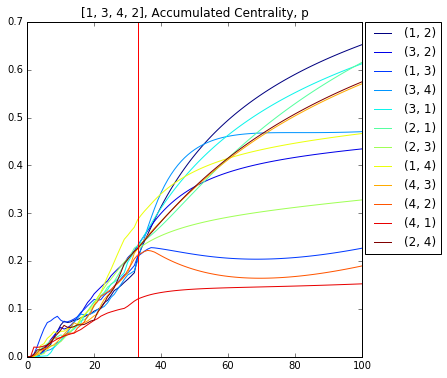

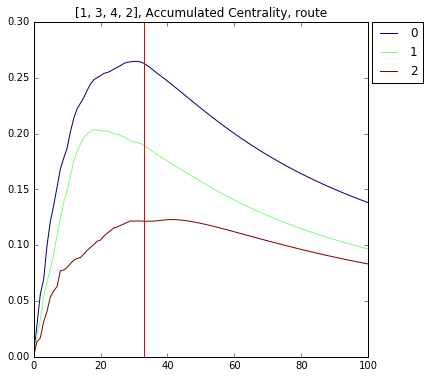

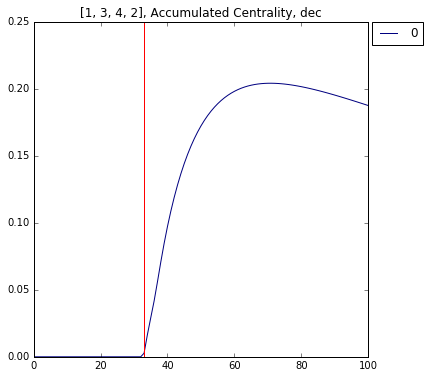

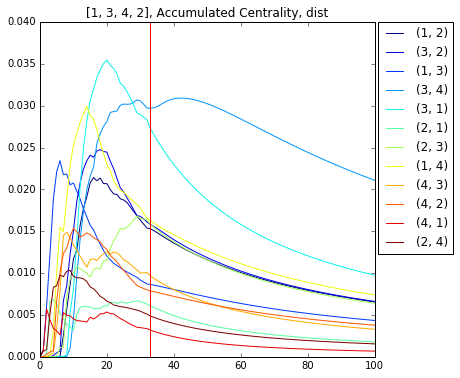

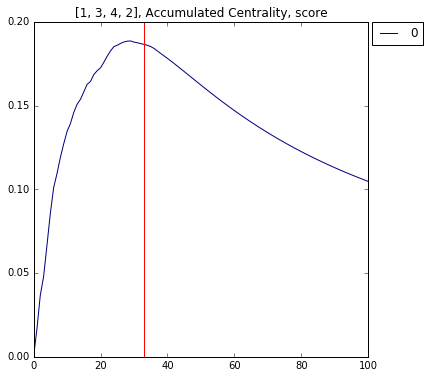

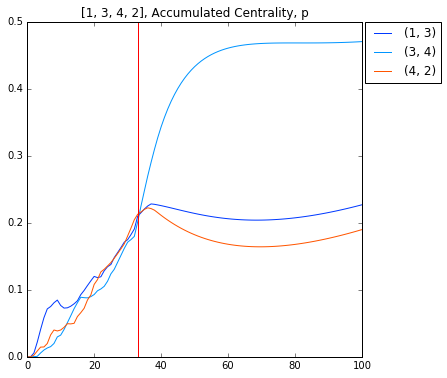

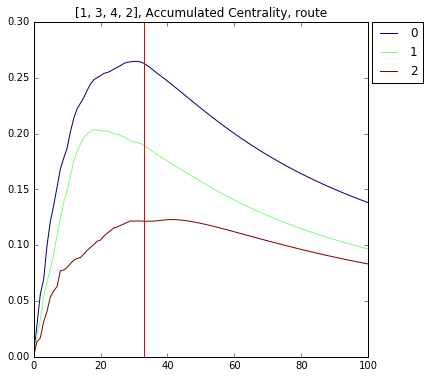

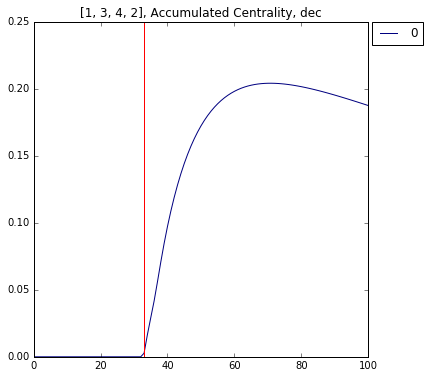

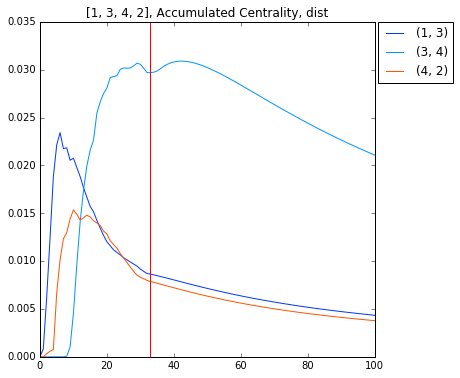

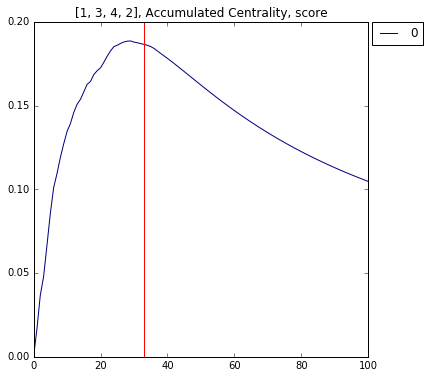

In [248]:
e_r=[tuple(t.d[i:i+2]) for i in xrange(0,len(t.d), 1)]
del e_r[-1]
        


results={}

for s,kd in t.history_k.iteritems():
    #c=nx.closeness_centrality(kd,normalized=True)
    c=nx.betweenness_centrality(kd,normalized=True)
    for k in t.last:
        results.setdefault(k,{})
        for e in t.last[k]:
            n_list=t.last[k][e]
            tc=0.0
            for n in n_list:
                if n in c:
                    tc+=c[n]
                #else:
                    #continue
            
            add=results[k].setdefault(e,[])
            add.append(tc)

#Plotting results
dec_only=False
x=range(t.step)
#print x
cmap=cm.get_cmap('jet')
for k,ele in results.iteritems():
    plt.figure(figsize=(6,6))
    N=len(ele.keys())
    i=0
    for e,series in ele.iteritems():
        #print series
        if N>1:
            c=cmap(float(i)/(N-1))
        else:
            c=cmap(0)
        if dec_only:
            if type(e)==tuple:
                if e in e_r:
                    plt.plot(x,series,label='{}'.format(e),color=c)
            else:
                plt.plot(x,series,label='{}'.format(e),color=c)
        else:
            plt.plot(x,series,label='{}'.format(e),color=c)
        i+=1
    
    for i in xrange(len(t.d_change)):
        #print t.d_change[i]
        plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
    plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
    plt.title('{}, Accumulated Centrality, {}'.format(t.d,k))
    
    
dec_only=True
for k,ele in results.iteritems():
    plt.figure(figsize=(6,6))
    N=len(ele.keys())
    i=0
    for e,series in ele.iteritems():
        #print series
        if N>1:
            c=cmap(float(i)/(N-1))
        else:
            c=cmap(0)
        if dec_only:
            if type(e)==tuple:
                if e in e_r:
                    plt.plot(x,series,label='{}'.format(e),color=c)
            else:
                plt.plot(x,series,label='{}'.format(e),color=c)
        else:
            plt.plot(x,series,label='{}'.format(e),color=c)
        i+=1
    
    for i in xrange(len(t.d_change)):
        #print t.d_change[i]
        plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
    plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
    plt.title('{}, Accumulated Centrality, {}'.format(t.d,k))

        
        
#print results

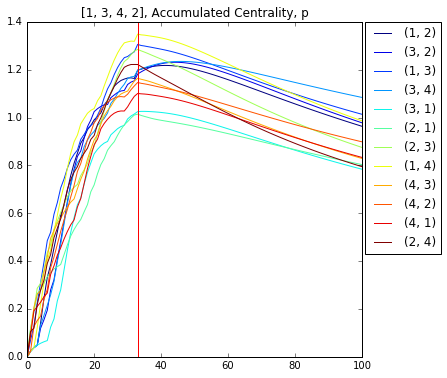

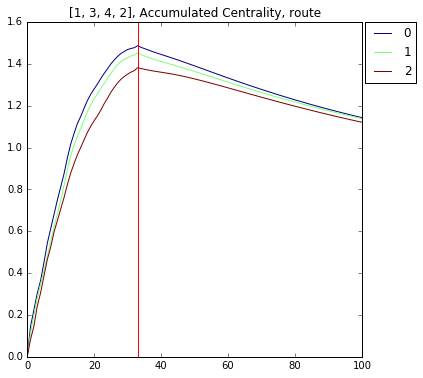

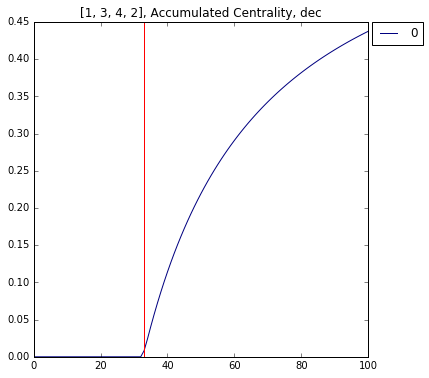

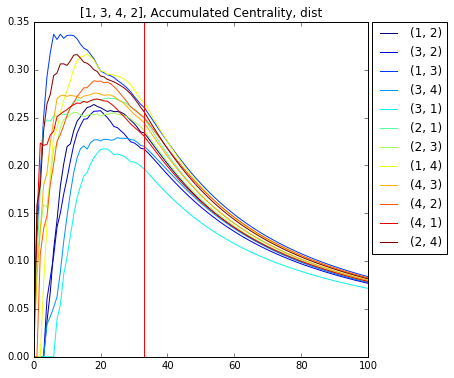

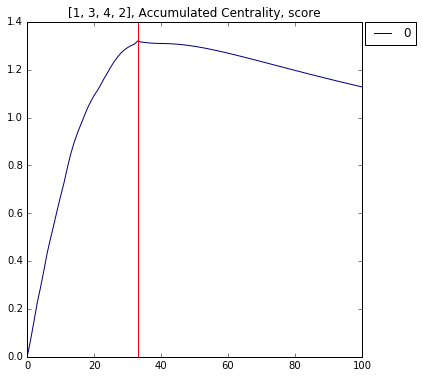

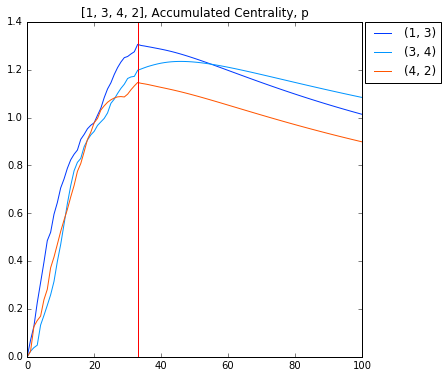

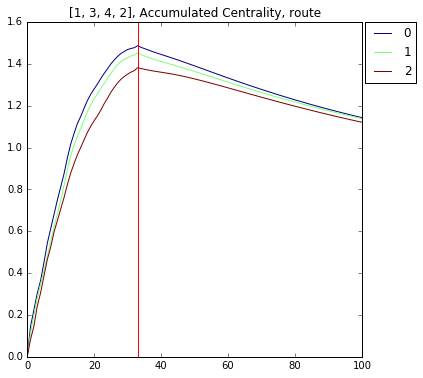

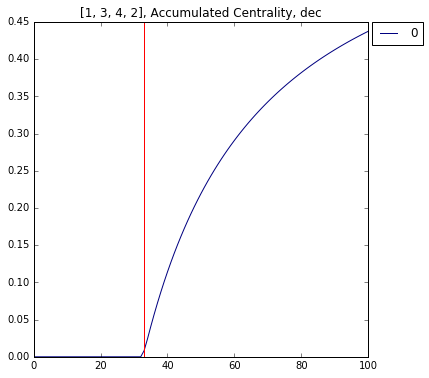

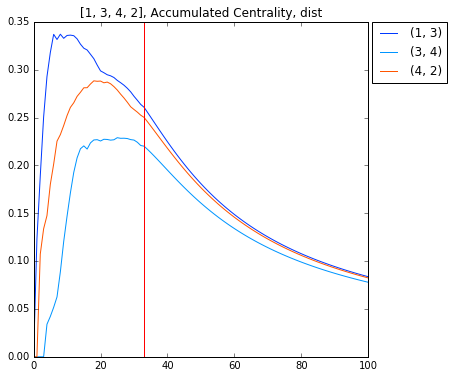

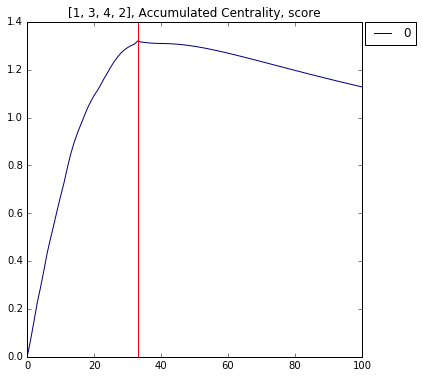

In [249]:
e_r=[tuple(t.d[i:i+2]) for i in xrange(0,len(t.d), 1)]
del e_r[-1]
        


results={}

for s,kd in t.history_k.iteritems():
    c=nx.closeness_centrality(kd,normalized=True)
    #c=nx.betweenness_centrality(kd,normalized=True)
    for k in t.last:
        results.setdefault(k,{})
        for e in t.last[k]:
            n_list=t.last[k][e]
            tc=0.0
            for n in n_list:
                if n in c:
                    tc+=c[n]
                #else:
                    #continue
            
            add=results[k].setdefault(e,[])
            add.append(tc)

#Plotting results
dec_only=False
x=range(t.step)
#print x
cmap=cm.get_cmap('jet')
for k,ele in results.iteritems():
    plt.figure(figsize=(6,6))
    N=len(ele.keys())
    i=0
    for e,series in ele.iteritems():
        #print series
        if N>1:
            c=cmap(float(i)/(N-1))
        else:
            c=cmap(0)
        if dec_only:
            if type(e)==tuple:
                if e in e_r:
                    plt.plot(x,series,label='{}'.format(e),color=c)
            else:
                plt.plot(x,series,label='{}'.format(e),color=c)
        else:
            plt.plot(x,series,label='{}'.format(e),color=c)
        i+=1
    
    for i in xrange(len(t.d_change)):
        #print t.d_change[i]
        plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
    plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
    plt.title('{}, Accumulated Centrality, {}'.format(t.d,k))
    
    
dec_only=True
for k,ele in results.iteritems():
    plt.figure(figsize=(6,6))
    N=len(ele.keys())
    i=0
    for e,series in ele.iteritems():
        #print series
        if N>1:
            c=cmap(float(i)/(N-1))
        else:
            c=cmap(0)
        if dec_only:
            if type(e)==tuple:
                if e in e_r:
                    plt.plot(x,series,label='{}'.format(e),color=c)
            else:
                plt.plot(x,series,label='{}'.format(e),color=c)
        else:
            plt.plot(x,series,label='{}'.format(e),color=c)
        i+=1
    
    for i in xrange(len(t.d_change)):
        #print t.d_change[i]
        plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
    plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
    plt.title('{}, Accumulated Centrality, {}'.format(t.d,k))

        
        
#print results

In [250]:
print results

{'p': {(1, 2): [0.0, 0.023255813953488372, 0.03825136612021858, 0.04852320675105485, 0.14068400547954768, 0.24414125284568267, 0.3319428563586602, 0.385186017205084, 0.45528073858548707, 0.5219266391928001, 0.5916319997203385, 0.6333742596847142, 0.6961764236846407, 0.7582027368494062, 0.8093116706760621, 0.8511612667132553, 0.8934222390369966, 0.9169022481395944, 0.9494317753038848, 0.9671468011534797, 0.9909262028142916, 1.004945516264834, 1.0201296593353275, 1.0531922399622435, 1.0720589524071449, 1.102432965841431, 1.1316959093868104, 1.1450726020747073, 1.1554809823500325, 1.161343796953098, 1.165732422493606, 1.1664004848765812, 1.1637825988318333, 1.199218065505792, 1.2025651077522093, 1.2072442441876756, 1.2104438396267327, 1.2130123176238214, 1.2151949929482424, 1.2168335984857956, 1.2178805705909956, 1.218337198568607, 1.218227791234406, 1.2175874108980116, 1.216455570606469, 1.2148728478967163, 1.2128790361784072, 1.2105121503330505, 1.2078079237181023, 1.2047995936623275, 1

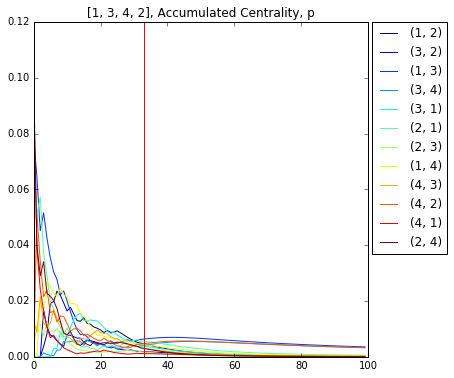

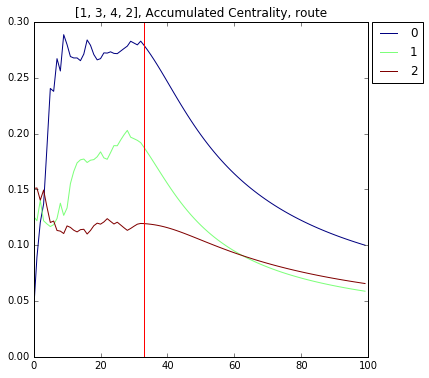

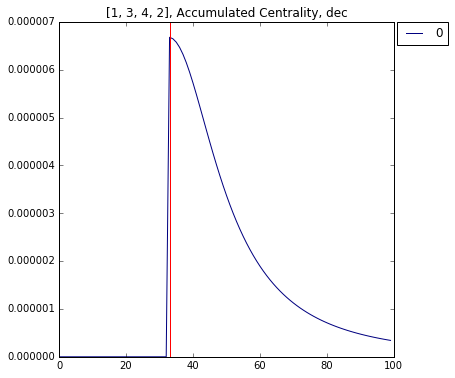

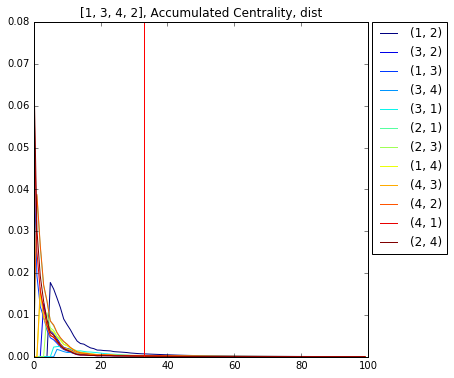

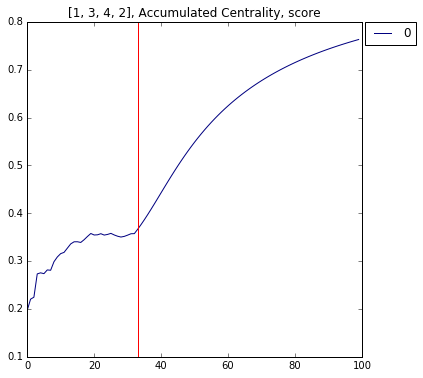

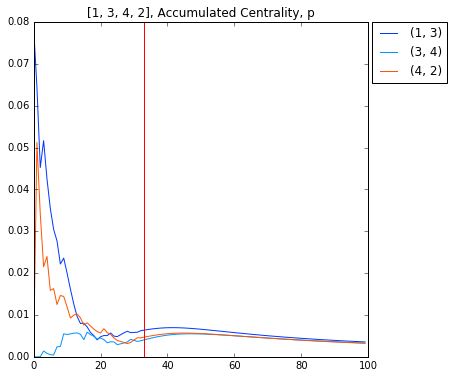

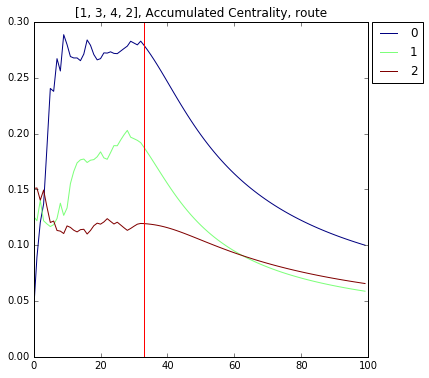

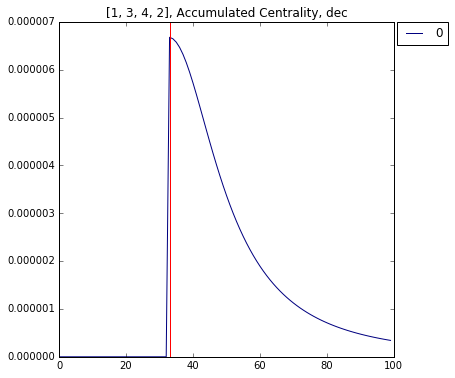

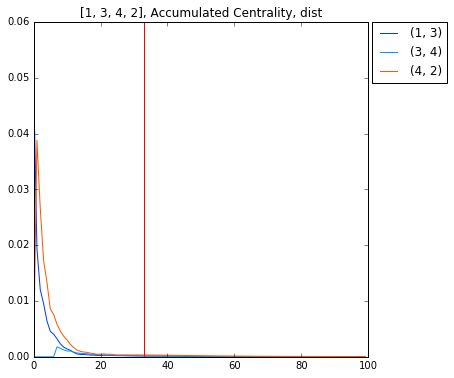

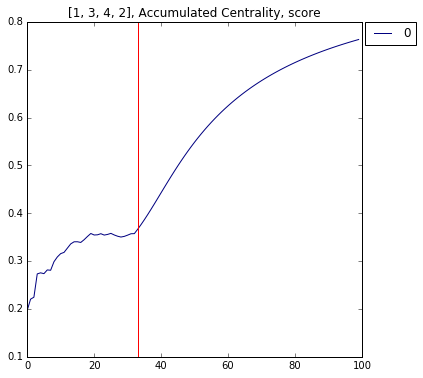

In [251]:
e_r=[tuple(t.d[i:i+2]) for i in xrange(0,len(t.d), 1)]
del e_r[-1]
        


results={}

for s,kd in t.history_k.iteritems():
    if s == 0:
        continue
    #print s
    (h,c)=nx.hits(kd,max_iter=10000,normalized=True) #(hubs,authorities)

    #c=nx.betweenness_centrality(kd,normalized=True)
    for k in t.last:
        results.setdefault(k,{})
        for e in t.last[k]:
            n_list=t.last[k][e]
            tc=0.0
            for n in n_list:
                if n in c:
                    tc+=c[n]
                #else:
                    #continue
            
            add=results[k].setdefault(e,[])
            add.append(tc)

#Plotting results
dec_only=False
x=range(t.step-1)
#print x
cmap=cm.get_cmap('jet')
for k,ele in results.iteritems():
    plt.figure(figsize=(6,6))
    N=len(ele.keys())
    i=0
    for e,series in ele.iteritems():
        #print series
        if N>1:
            c=cmap(float(i)/(N-1))
        else:
            c=cmap(0)
        if dec_only:
            if type(e)==tuple:
                if e in e_r:
                    plt.plot(x,series,label='{}'.format(e),color=c)
            else:
                plt.plot(x,series,label='{}'.format(e),color=c)
        else:
            plt.plot(x,series,label='{}'.format(e),color=c)
        i+=1
    
    for i in xrange(len(t.d_change)):
        #print t.d_change[i]
        plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
    plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
    plt.title('{}, Accumulated Centrality, {}'.format(t.d,k))
    
    
dec_only=True
for k,ele in results.iteritems():
    plt.figure(figsize=(6,6))
    N=len(ele.keys())
    i=0
    for e,series in ele.iteritems():
        #print series
        if N>1:
            c=cmap(float(i)/(N-1))
        else:
            c=cmap(0)
        if dec_only:
            if type(e)==tuple:
                if e in e_r:
                    plt.plot(x,series,label='{}'.format(e),color=c)
            else:
                plt.plot(x,series,label='{}'.format(e),color=c)
        else:
            plt.plot(x,series,label='{}'.format(e),color=c)
        i+=1
    
    for i in xrange(len(t.d_change)):
        #print t.d_change[i]
        plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
    plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
    plt.title('{}, Accumulated Centrality, {}'.format(t.d,k))

        
        
#print results

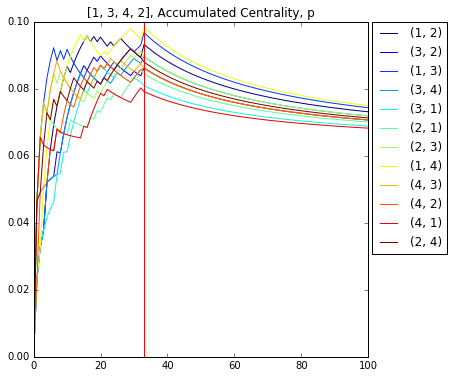

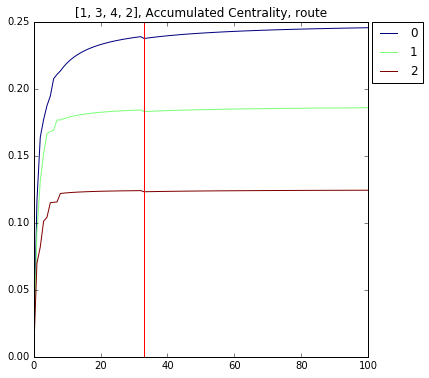

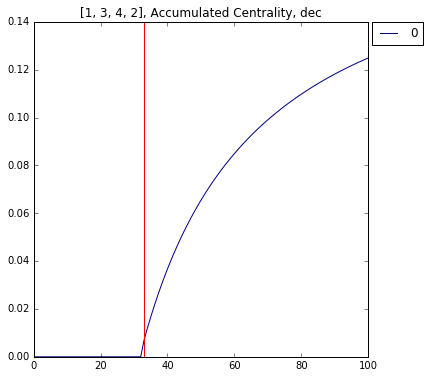

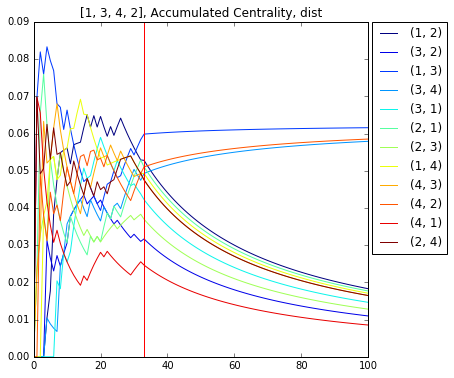

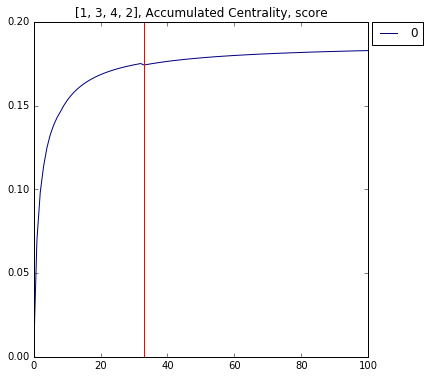

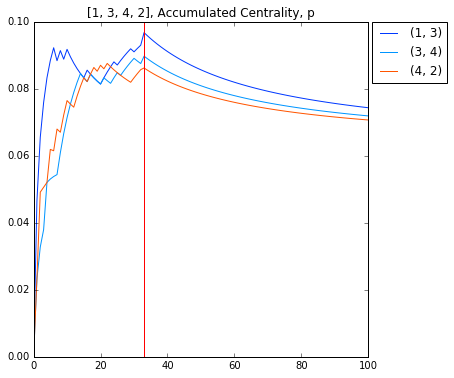

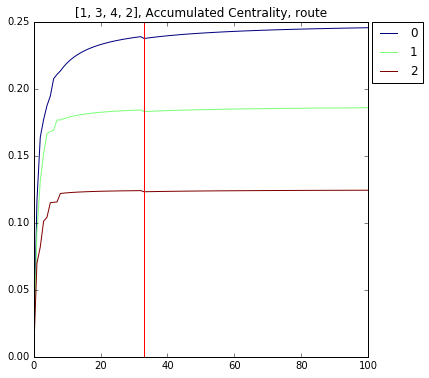

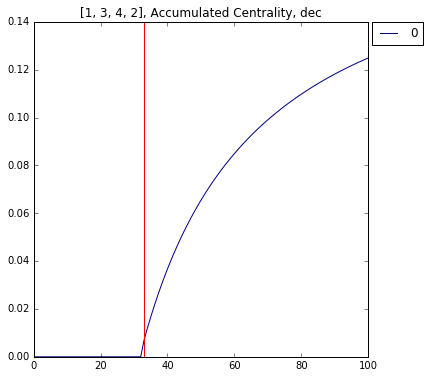

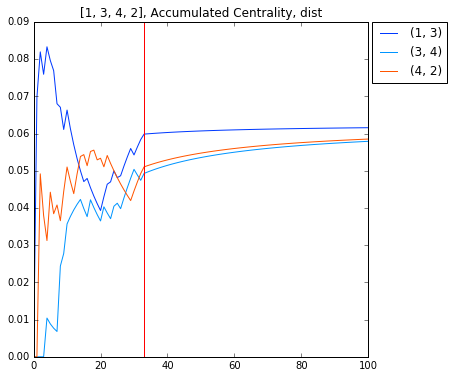

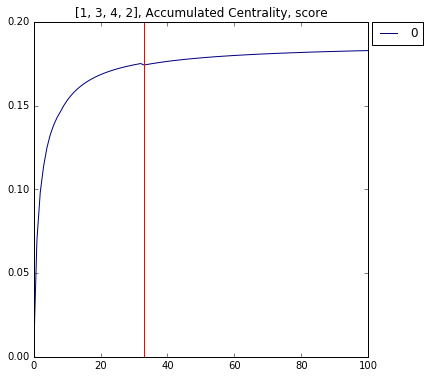

In [260]:
e_r=[tuple(t.d[i:i+2]) for i in xrange(0,len(t.d), 1)]
del e_r[-1]
        


results={}

for s,kd in t.history_k.iteritems():
    c=nx.out_degree_centrality(kd)
    #c=nx.closeness_centrality(kd,normalized=True)
    #c=nx.betweenness_centrality(kd,normalized=True)
    l=['p','dist','']
    for k in t.last:
        results.setdefault(k,{})
        for e in t.last[k]:
            n_list=t.last[k][e]
            tc=0.0
            for n in n_list:
                if n in c:
                    tc+=c[n]
                #else:
                    #continue
            
            add=results[k].setdefault(e,[])
            add.append(tc)

#Plotting results
dec_only=False
x=range(t.step)
#print x
cmap=cm.get_cmap('jet')
for k,ele in results.iteritems():
    plt.figure(figsize=(6,6))
    N=len(ele.keys())
    i=0
    for e,series in ele.iteritems():
        #print series
        if N>1:
            c=cmap(float(i)/(N-1))
        else:
            c=cmap(0)
        if dec_only:
            if type(e)==tuple:
                if e in e_r:
                    plt.plot(x,series,label='{}'.format(e),color=c)
            else:
                plt.plot(x,series,label='{}'.format(e),color=c)
        else:
            plt.plot(x,series,label='{}'.format(e),color=c)
        i+=1
    
    for i in xrange(len(t.d_change)):
        #print t.d_change[i]
        plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
    plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
    plt.title('{}, Accumulated Centrality, {}'.format(t.d,k))
    
    
dec_only=True
for k,ele in results.iteritems():
    plt.figure(figsize=(6,6))
    N=len(ele.keys())
    i=0
    for e,series in ele.iteritems():
        #print series
        if N>1:
            c=cmap(float(i)/(N-1))
        else:
            c=cmap(0)
        if dec_only:
            if type(e)==tuple:
                if e in e_r:
                    plt.plot(x,series,label='{}'.format(e),color=c)
            else:
                plt.plot(x,series,label='{}'.format(e),color=c)
        else:
            plt.plot(x,series,label='{}'.format(e),color=c)
        i+=1
    
    for i in xrange(len(t.d_change)):
        #print t.d_change[i]
        plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
    plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
    plt.title('{}, Accumulated Centrality, {}'.format(t.d,k))

        
        
#print results

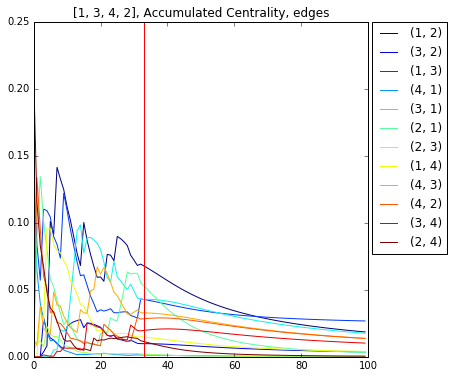

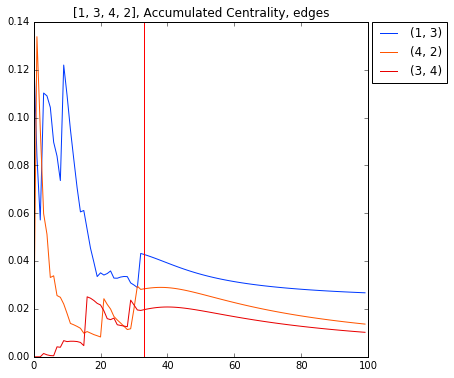

In [256]:
e_r=[tuple(t.d[i:i+2]) for i in xrange(0,len(t.d), 1)]
del e_r[-1]
        
#get composite edge data from 'p','dist', and 'selection'

results={}

for e in t.state.edges():
    results[e]=[]
    


for s,kd in t.history_k.iteritems():
    if s == 0:
        continue
    #print s
    (h,c)=nx.hits(kd,max_iter=10000,normalized=True) #(hubs,authorities)

    #c=nx.betweenness_centrality(kd,normalized=True)
    for e in results.keys():
        tc=0.0
        #contribution from pheromone
        n_list=t.last['p'][e]
        for n in n_list:
            if n in c:
                tc+=c[n]
                
        #contribution from distance
        n_list=t.last['dist'][e]
        for n in n_list:
            if n in c:
                tc+=c[n]
        
        #contribution from route
        n_list=t.last['route'][0]
        for n in n_list:
            if n in c:
                if t.k.node[n]['e']==e:
                    tc+=c[n]

        results[e].append(tc)

#Plotting results
dec_only=False
x=range(t.step-1)
#print x
cmap=cm.get_cmap('jet')
N=len(results.keys())
i=0
plt.figure(figsize=(6,6))
for k,series in results.iteritems():

    
    if N>1:
        c=cmap(float(i)/(N-1))
    else:
        c=cmap(0)
        
    if dec_only:
        if k in e_r:
            plt.plot(x,series,label='{}'.format(k),color=c)

    else:
        plt.plot(x,series,label='{}'.format(k),color=c)
    i+=1
    
for i in xrange(len(t.d_change)):
    #print t.d_change[i]
    plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))

plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
plt.title('{}, Accumulated Centrality, edges'.format(t.d,k))
    
    
dec_only=True
cmap=cm.get_cmap('jet')
N=len(results.keys())
i=0    
plt.figure(figsize=(6,6))
for k,series in results.iteritems(): 
    if N>1:
        c=cmap(float(i)/(N-1))
    else:
        c=cmap(0)
        
    if dec_only:
        if k in e_r:
            plt.plot(x,series,label='{}'.format(k),color=c)

    else:
        plt.plot(x,series,label='{}'.format(k),color=c)
    i+=1
    
for i in xrange(len(t.d_change)):
    #print t.d_change[i]
    plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
plt.title('{}, Accumulated Centrality, edges'.format(t.d,k))

        
        
#print results

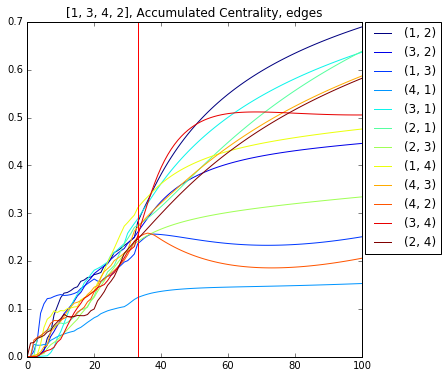

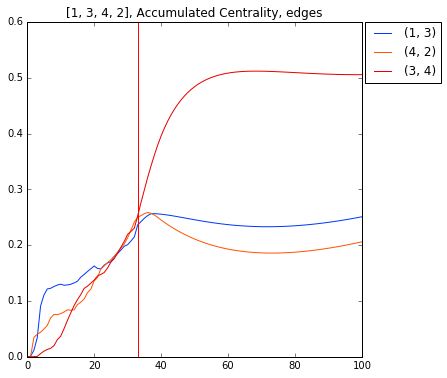

In [254]:
e_r=[tuple(t.d[i:i+2]) for i in xrange(0,len(t.d), 1)]
del e_r[-1]
        
#get composite edge data from 'p','dist', and 'selection'

results={}

for e in t.state.edges():
    results[e]=[]
    


for s,kd in t.history_k.iteritems():
    #if s == 0:
        #continue
    #print s
    #(c,a)=nx.hits(kd,max_iter=10000,normalized=True) #(hubs,authorities)
    #c=nx.closeness_centrality(kd,normalized=True)
    c=nx.betweenness_centrality(kd,normalized=True)
    for e in results.keys():
        tc=0.0
        #contribution from pheromone
        n_list=t.last['p'][e]
        for n in n_list:
            if n in c:
                tc+=c[n]
                
        #contribution from distance
        n_list=t.last['dist'][e]
        for n in n_list:
            if n in c:
                tc+=c[n]
        
        #contribution from route
        n_list=t.last['route'][0]
        for n in n_list:
            if n in c:
                if t.k.node[n]['e']==e:
                    tc+=c[n]

        results[e].append(tc)

#Plotting results
dec_only=False
x=range(t.step)
#print x
cmap=cm.get_cmap('jet')
N=len(results.keys())
i=0
plt.figure(figsize=(6,6))
for k,series in results.iteritems():

    
    if N>1:
        c=cmap(float(i)/(N-1))
    else:
        c=cmap(0)
        
    if dec_only:
        if k in e_r:
            plt.plot(x,series,label='{}'.format(k),color=c)

    else:
        plt.plot(x,series,label='{}'.format(k),color=c)
    i+=1
    
for i in xrange(len(t.d_change)):
    #print t.d_change[i]
    plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))

plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
plt.title('{}, Accumulated Centrality, edges'.format(t.d,k))
    
    
dec_only=True
cmap=cm.get_cmap('jet')
N=len(results.keys())
i=0    
plt.figure(figsize=(6,6))
for k,series in results.iteritems(): 
    if N>1:
        c=cmap(float(i)/(N-1))
    else:
        c=cmap(0)
        
    if dec_only:
        if k in e_r:
            plt.plot(x,series,label='{}'.format(k),color=c)

    else:
        plt.plot(x,series,label='{}'.format(k),color=c)
    i+=1
    
for i in xrange(len(t.d_change)):
    #print t.d_change[i]
    plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
plt.title('{}, Accumulated Centrality, edges'.format(t.d,k))

        
        
#print results

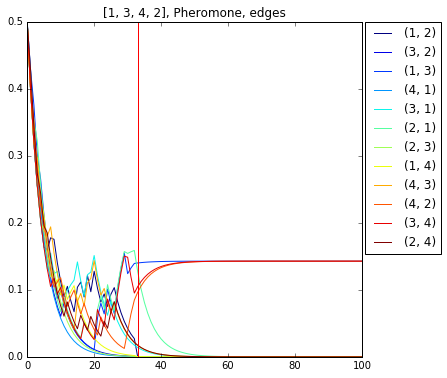

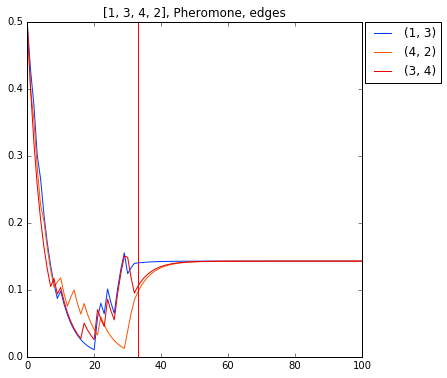

In [255]:
#plot pheromones over time
results={}
for s,g in t.history_s.iteritems():
    for u,v,d in g.edges(data=True):
        add=results.setdefault((u,v),[])
        add.append(d['p'])

#Plotting results
dec_only=False
x=range(t.step)
#print x
cmap=cm.get_cmap('jet')
N=len(results.keys())
i=0
plt.figure(figsize=(6,6))
for k,series in results.iteritems():
    
    if N>1:
        c=cmap(float(i)/(N-1))
    else:
        c=cmap(0)
        
    if dec_only:
        if k in e_r:
            plt.plot(x,series,label='{}'.format(k),color=c)

    else:
        plt.plot(x,series,label='{}'.format(k),color=c)
    i+=1
    
for i in xrange(len(t.d_change)):
    #print t.d_change[i]
    plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))

plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
plt.title('{}, Pheromone, edges'.format(t.d,k))
    
    
dec_only=True
cmap=cm.get_cmap('jet')
N=len(results.keys())
i=0    
plt.figure(figsize=(6,6))
for k,series in results.iteritems(): 
    if N>1:
        c=cmap(float(i)/(N-1))
    else:
        c=cmap(0)
        
    if dec_only:
        if k in e_r:
            plt.plot(x,series,label='{}'.format(k),color=c)

    else:
        plt.plot(x,series,label='{}'.format(k),color=c)
    i+=1
    
for i in xrange(len(t.d_change)):
    #print t.d_change[i]
    plt.axvline(x=t.d_change[i], color='r')#, label='decision {}'.format(i))
        
plt.legend(bbox_to_anchor=(1.01,1),loc=2,borderaxespad=0.) 
plt.title('{}, Pheromone, edges'.format(t.d,k))        
        
        
        
#print results

In [185]:
print t.d
print t.d_change

[2, 4, 1, 3, 0]
[68, 68, 68, 68, 68]


In [137]:
print t.history_s[63].edges(data=True)

[(1, 2, {'p': 0.097356416678024, 'dist': 1.0}), (1, 3, {'p': 0.0002171208260073862, 'dist': 1.0}), (1, 4, {'p': 0.004503977173461586, 'dist': 2.0}), (2, 1, {'p': 0.005073328888963519, 'dist': 1.0}), (2, 3, {'p': 0.11827754509911671, 'dist': 3.0}), (2, 4, {'p': 4.6412722094795643e-07, 'dist': 4.0}), (3, 1, {'p': 2.3445687216993814e-06, 'dist': 1.0}), (3, 2, {'p': 0.0005301244231969481, 'dist': 3.0}), (3, 4, {'p': 0.10862917372770761, 'dist': 2.0}), (4, 1, {'p': 0.15248345780008388, 'dist': 2.0}), (4, 2, {'p': 5.0036933686317904e-05, 'dist': 4.0}), (4, 3, {'p': 0.004750987238905275, 'dist': 2.0})]


In [145]:
print t.history_s[44].edges(data=True)

[(1, 2, {'p': 0.17630121655915937, 'dist': 1.0}), (1, 3, {'p': 0.002914050941189232, 'dist': 1.0}), (1, 4, {'p': 3.385607001835417e-05, 'dist': 2.0}), (2, 1, {'p': 0.0021804047981469486, 'dist': 1.0}), (2, 3, {'p': 8.307625730983438e-05, 'dist': 3.0}), (2, 4, {'p': 0.0729397908503985, 'dist': 4.0}), (3, 1, {'p': 0.17925903022779338, 'dist': 1.0}), (3, 2, {'p': 0.0, 'dist': 3.0}), (3, 4, {'p': 0.0028723393207540134, 'dist': 2.0}), (4, 1, {'p': 0.0, 'dist': 2.0}), (4, 2, {'p': 0.0, 'dist': 4.0}), (4, 3, {'p': 0.16943380969505506, 'dist': 2.0})]


In [94]:
print t.history_s[58].edges(data=True)

[(1, 2, {'p': 9.864424560034993e-05, 'dist': 1.0}), (1, 3, {'p': 0.1494414676412827, 'dist': 1.0}), (1, 4, {'p': 0.0007996007581878906, 'dist': 2.0}), (2, 1, {'p': 0.16024708016731717, 'dist': 1.0}), (2, 3, {'p': 0.0, 'dist': 3.0}), (2, 4, {'p': 0.003541290590583066, 'dist': 4.0}), (3, 1, {'p': 1.5503365785200036e-06, 'dist': 1.0}), (3, 2, {'p': 0.003578526385616484, 'dist': 3.0}), (3, 4, {'p': 0.03909236332699536, 'dist': 2.0}), (4, 1, {'p': 0.0, 'dist': 2.0}), (4, 2, {'p': 0.1456968404194434, 'dist': 4.0}), (4, 3, {'p': 0.0, 'dist': 2.0})]


In [156]:
n=730
print 'node =',n,t.k.node[n]
for i in t.k.neighbors(n):
    print i, t.k.node[i]

node = 730 {'p': 0.17630121655915937, 'step': 44, 'label': (1, 2)}
750 {'p': 0.1910409732473275, 'step': 45, 'label': (1, 2)}


In [161]:
e=(3,2)
for n in t.last['p'][e]:
    print n, t.k.node[n]
    for i in t.k.predecessors(n):
        print ' ',i, t.k.node[i]

23 {'p': 0.5, 'step': 0, 'label': (4, 3)}
44 {'p': 0.4, 'step': 1, 'label': (4, 3)}
  23 {'p': 0.5, 'step': 0, 'label': (4, 3)}
63 {'p': 0.32000000000000006, 'step': 2, 'label': (4, 3)}
  44 {'p': 0.4, 'step': 1, 'label': (4, 3)}
81 {'p': 0.25600000000000006, 'step': 3, 'label': (4, 3)}
  63 {'p': 0.32000000000000006, 'step': 2, 'label': (4, 3)}
98 {'p': 0.23337142857142865, 'step': 4, 'label': (4, 3)}
  81 {'p': 0.25600000000000006, 'step': 3, 'label': (4, 3)}
  83 {'i': 1, 'step': 4, 'e': (4, 3), 'label': 'selection'}
  86 {'step': 4, 'score': 7.0, 'label': 'score'}
114 {'p': 0.18669714285714292, 'step': 5, 'label': (4, 3)}
  98 {'p': 0.23337142857142865, 'step': 4, 'label': (4, 3)}
131 {'p': 0.14935771428571434, 'step': 6, 'label': (4, 3)}
  114 {'p': 0.18669714285714292, 'step': 5, 'label': (4, 3)}
149 {'p': 0.14805760000000007, 'step': 7, 'label': (4, 3)}
  137 {'step': 7, 'score': 7.0, 'label': 'score'}
  131 {'p': 0.14935771428571434, 'step': 6, 'label': (4, 3)}
  133 {'i': 1, '

In [230]:
for e,d in results.iteritems():
    print e,d[20]

(0, 1) 0.00313803717668
(1, 2) 0.0124936555352
(3, 2) 0.0127096424902
(1, 3) 0.00838046974913
(3, 0) 0.0194858326247
(4, 1) 0.00650653731146
(4, 2) 0.00284561943969
(3, 1) 0.0364469752197
(1, 4) 0.00626681399434
(0, 2) 0.00299074322409
(2, 0) 0.0132484537488
(2, 3) 0.000882085422561
(2, 1) 0.00293538141831
(4, 3) 0.00262240919726
(0, 4) 0.0256148124628
(2, 4) 0.0319110964583
(0, 3) 0.102213210003
(3, 4) 0.0232399537746
(1, 0) 0.0027504616667
(4, 0) 0.00151186453958


In [206]:
e=(1,0)
for n in t.last['dist'][e]:
    print n, t.k.node[n]
    for i in t.k.successors(n):
    #for i in t.k.predecessors(n):
        print ' ',i, t.k.node[i]

10 {'step': 0, 'dist': 0.0, 'label': (1, 0)}
  128 {'i': 0, 'step': 4, 'e': (1, 4), 'label': 'selection'}
  289 {'step': 10, 'dist': 2.0, 'label': (1, 0)}
  235 {'i': 1, 'step': 8, 'e': (1, 2), 'label': 'selection'}
  182 {'i': 0, 'step': 6, 'e': (1, 3), 'label': 'selection'}
  287 {'i': 2, 'step': 10, 'e': (1, 0), 'label': 'selection'}
289 {'step': 10, 'dist': 2.0, 'label': (1, 0)}
  513 {'i': 2, 'step': 19, 'e': (1, 0), 'label': 'selection'}
  290 {'step': 10, 'score': 7.0, 'label': 'score'}
  515 {'step': 19, 'score': 7.0, 'label': 'score'}
  586 {'i': 0, 'step': 22, 'e': (1, 3), 'label': 'selection'}
  711 {'i': 0, 'step': 27, 'e': (1, 3), 'label': 'selection'}
  362 {'i': 1, 'step': 13, 'e': (1, 2), 'label': 'selection'}
  811 {'i': 0, 'step': 31, 'e': (1, 3), 'label': 'selection'}
  686 {'i': 0, 'step': 26, 'e': (1, 3), 'label': 'selection'}
  911 {'i': 0, 'step': 35, 'e': (1, 3), 'label': 'selection'}
  464 {'i': 3, 'step': 17, 'e': (1, 0), 'label': 'selection'}
  465 {'step': 1

In [204]:
e=(4,2)
for n in t.last['dist'][e]:
    print n, t.k.node[n]
    for i in t.k.successors(n):
    #for i in t.k.predecessors(n):
        print ' ',i, t.k.node[i]

38 {'step': 0, 'dist': 0.0, 'label': (4, 2)}
  129 {'i': 1, 'step': 4, 'e': (4, 3), 'label': 'selection'}
  260 {'i': 1, 'step': 9, 'e': (4, 2), 'label': 'selection'}
  263 {'step': 9, 'dist': 2.0, 'label': (4, 2)}
  72 {'i': 1, 'step': 2, 'e': (4, 3), 'label': 'selection'}
  42 {'i': 0, 'step': 1, 'e': (4, 3), 'label': 'selection'}
  211 {'i': 2, 'step': 7, 'e': (4, 1), 'label': 'selection'}
  156 {'i': 2, 'step': 5, 'e': (4, 1), 'label': 'selection'}
263 {'step': 9, 'dist': 2.0, 'label': (4, 2)}
  1067 {'step': 41, 'score': 8.0, 'label': 'score'}
  388 {'i': 2, 'step': 14, 'e': (4, 2), 'label': 'selection'}
  790 {'step': 30, 'score': 8.0, 'label': 'score'}
  390 {'step': 14, 'score': 8.0, 'label': 'score'}
  264 {'step': 9, 'score': 8.0, 'label': 'score'}
  1292 {'i': 3, 'step': 50, 'e': (4, 2), 'label': 'selection'}
  1293 {'step': 50, 'score': 8.0, 'label': 'score'}
  786 {'i': 0, 'step': 30, 'e': (4, 2), 'label': 'selection'}
  915 {'step': 35, 'score': 8.0, 'label': 'score'}
  6

In [198]:
s=40
for u,v,d in t.history_s[s].edges(data=True):
    print (u,v),d
#print t.history_s[40].edges(data=True)

(0, 1) {'p': 0.0279158698065316, 'dist': 2.0}
(0, 2) {'p': 0.014465636648145761, 'dist': 2.0}
(0, 3) {'p': 0.049726382210391704, 'dist': 2.0}
(0, 4) {'p': 0.008384160941672653, 'dist': 2.0}
(1, 0) {'p': 0.0008706756189625494, 'dist': 2.0}
(1, 2) {'p': 0.06863085695105828, 'dist': 2.0}
(1, 3) {'p': 0.04689944441703407, 'dist': 2.0}
(1, 4) {'p': 0.0005233117335994644, 'dist': 2.0}
(2, 0) {'p': 0.08570634700491497, 'dist': 2.0}
(2, 1) {'p': 0.00998456128203071, 'dist': 2.0}
(2, 3) {'p': 0.00068918266357457, 'dist': 2.0}
(2, 4) {'p': 0.0011386222378445014, 'dist': 1.0}
(3, 0) {'p': 0.009445276077189348, 'dist': 2.0}
(3, 1) {'p': 0.003629634378638809, 'dist': 2.0}
(3, 2) {'p': 0.00016090872944663902, 'dist': 2.0}
(3, 4) {'p': 0.0974367259600212, 'dist': 2.0}
(4, 0) {'p': 0.0001538644231469354, 'dist': 2.0}
(4, 1) {'p': 0.05883090141345335, 'dist': 2.0}
(4, 2) {'p': 0.011720359280179579, 'dist': 2.0}
(4, 3) {'p': 0.0054861252371867395, 'dist': 2.0}


In [217]:
print t.history_k

{0: <networkx.classes.digraph.DiGraph object at 0x0000000332A4C898>, 1: <networkx.classes.digraph.DiGraph object at 0x00000003C1FDFB38>, 2: <networkx.classes.digraph.DiGraph object at 0x00000003D0D42EB8>, 3: <networkx.classes.digraph.DiGraph object at 0x00000003D0D429B0>, 4: <networkx.classes.digraph.DiGraph object at 0x00000003D0D42D68>, 5: <networkx.classes.digraph.DiGraph object at 0x00000003D0D424A8>, 6: <networkx.classes.digraph.DiGraph object at 0x00000003D0D42EF0>, 7: <networkx.classes.digraph.DiGraph object at 0x00000003D0D42A20>, 8: <networkx.classes.digraph.DiGraph object at 0x00000003D0D42748>, 9: <networkx.classes.digraph.DiGraph object at 0x00000003D0D42128>, 10: <networkx.classes.digraph.DiGraph object at 0x00000003D0D42278>, 11: <networkx.classes.digraph.DiGraph object at 0x00000003D0D42630>, 12: <networkx.classes.digraph.DiGraph object at 0x00000003D0D42F98>, 13: <networkx.classes.digraph.DiGraph object at 0x00000003D0D42A58>, 14: <networkx.classes.digraph.DiGraph objec